# River Boundary Masking

## Introduction

Cold water refuges are crucial havens for fish species, offering them sanctuary and relief. These refuges are specific areas within aquatic ecosystems, such as deep pools or shaded sections, where the water remains relatively colder than the surrounding environment. With the increasing impact of climate change and its associated rising temperatures, cold water refuges serve as essential habitats for fish, providing them with a reprieve from stressful conditions and enabling their survival and reproductive success. By seeking out these refuges, fish can maintain optimal physiological functioning, evade thermal stress, and ensure the long-term sustainability of their populations.

In this section, we will use our realign dataset to create river masks for our IR images. These masks will then be used to identify cold water refuges in the river in the next section. The segmentation model selected for use is Meta's SAM. The workflow overview of how it is utilized to create river masks is as follows:

* Create a small training dataset by hand using paint.net
* Split said dataset into training, testing and validation
* Create mechanism for creating point prompts for SAM
* Fine tune SAM via transfer learning on the training data
* Evaluate model performance and generate masks

## Dataset

The first step is to build our ground truth dataset. It seems that the original processing done in 2012 included some preliminary river masks. Unfortunately, these masks are fairly poor. They also do not help with the construction of our ground truth dataset; it is easier to just manually create new masks than it is to patch up the existing masks.

The process of creating ground truth masks involves using the magic wand tool in paint.net, which selects an contiguous area of similar color based on some tolerance value. Then this area is filled with black and the rest of the image with white, and the mask can then be manually adjusted to match the river in areas where the magic wand fails to align perfectly with the river edge. 

The optimal results are achieved by using RGB images layered with transparency over the IR images, as the IR images have the highest contrast between river and non-river pixels. This is because reflectance of water is lower than soil and vegetation across a wide range of the electromagnetic spectrum, including within the visible RGB portion, but the difference is most significant in the IR range.

![Quadrant Filtering](../img/reflectance.png)

The difference in reflectance then results in the contrast between the river and land pixels being larger in the IR images. This also means that while both the RGB and IR remote sensing imagery may prove relevant to the model, the IR images will be the key to accurate segmentation. 

In [1]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [64]:
import util
import numpy as np
import ipywidgets as widgets
from PIL import Image as im
import matplotlib.pyplot as plt
from IPython.display import display

# System and typing
from pathlib import Path
from typing import Any, Callable, Optional

# Finding central points
from skimage.morphology import erosion

import cv2
import torch
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
# from torchvision import transforms

Now that we have our ground truth masks, we need a PyTorch datastructure through which we can use them. We will extend the VisionDataset class, creating our own SegmentationDataset class which has support for transforms. This will come in handy later when we do dataset augmentation.

In [65]:
"""
Adapted from Manpreet Singh Minhas's transfer learning
for semantic segmentation tutorial.
"""

class SegmentationDataset(VisionDataset):
  """A PyTorch dataset for image segmentation task.
  The dataset is compatible with torchvision transforms.
  The transforms passed would be applied to both the Images and Masks.
  """
  def __init__(self,
    root: str,
    ir_folder: str,
    rgb_folder: str,
    masks_folder: str,

    ir_prefix: str,
    rgb_prefix: str,
    masks_prefix: str,

    transforms: Optional[Callable] = None,
    seed: int = None,
    fraction: float = None,
    subset: str = None,
    
    mask_color_mode: str = "grayscale") -> None:
    """
    ARGS:
      root (str): Used for super init of VisionDataset.
      ir_folder (str): Folder containing the ir images.
      rgb_folder (str): Folder containing the rgb images.
      masks_folder (str): Folder containing the segmentation truth mask images.
      ir_prefix (str): Prefix string for ir images, e.g. "ir_image_" if stored as ir_image_1, ir_image_2 ...
      rgb_prefix (str): Prefix string for the rgb images.
      masks_prefix (str): Prefix string for the segmentation truth mask images.

      transforms (Optional[Callable], optional): A function/transform that takes in
          a sample and returns a transformed version. E.g, ``transforms.ToTensor`` for images.
      seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
      fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
      subset (str, optional): "Train" or "Test" to select the appropriate set. Defaults to None.

      mask_color_mode (str, optional): "rgb" or "grayscale". Defaults to "grayscale".
    
    RAISES:
      OSError: If any of ir_folder, rgb_folder or masks_folder do not exist.
      ValueError: If subset is not either "Train" or "Test".
      ValueError: If image_color_mode and mask_color_mode are either "rgb" or "grayscale".
    """
    super().__init__(root, transforms)

    ir_images_path = Path(self.root) / ir_folder
    rgb_images_path = Path(self.root) / rgb_folder
    mask_images_path = Path(self.root) / masks_folder

    if not ir_images_path.exists():
      raise OSError(f"{ir_images_path} does not exist.")
    if not rgb_images_path.exists():
      raise OSError(f"{rgb_images_path} does not exist.")
    if not mask_images_path.exists():
      raise OSError(f"{mask_images_path} does not exist.")

    if mask_color_mode not in ["rgb", "grayscale"]:
      raise ValueError(f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale.")
    self.mask_color_mode = mask_color_mode

    if not fraction:
      self.mask_names = sorted(mask_images_path.glob(masks_prefix + "*"))
    else:
      if subset not in ["Train", "Test"]:
        raise ValueError(f"{subset} is not a valid input. Acceptable values are Train and Test.")
      
      self.fraction = fraction
      self.mask_list = np.array(sorted(mask_images_path.glob(masks_prefix + "*"), key=util.onlyNumeric))
      print(f"Found and loaded {len(self.mask_list)} ground truth segmentation masks.")
      
      # we don't have an rgb reconstruction for every ir image
      # and definitely don't have a mask for every rgb + ir pair
      self.ir_image_list = []
      self.rgb_image_list = []
      for mask in self.mask_list:
        number = util.onlyNumeric(mask)
        self.ir_image_list.append(ir_images_path / (ir_prefix + number + ".png"))
        self.rgb_image_list.append(rgb_images_path / (rgb_prefix + number + ".png"))

      self.ir_image_list = np.array(self.ir_image_list)
      self.rgb_image_list = np.array(self.rgb_image_list)
      assert len(self.ir_image_list) == len(self.rgb_image_list) == len(self.mask_list)

      if seed:
        np.random.seed(seed)
        indices = np.arange(len(self.mask_list))
        np.random.shuffle(indices)

        self.ir_image_list = self.ir_image_list[indices]
        self.rgb_image_list = self.rgb_image_list[indices]
        self.mask_list = self.mask_list[indices]


      if subset == "Train":
        self.ir_image_names = self.ir_image_list[:int(
          np.ceil(len(self.ir_image_list) * (1 - self.fraction)))]
        self.rgb_image_names = self.rgb_image_list[:int(
          np.ceil(len(self.ir_image_list) * (1 - self.fraction)))]
        self.mask_names = self.mask_list[:int(
          np.ceil(len(self.mask_list) * (1 - self.fraction)))]
      else:
        self.ir_image_names = self.ir_image_list[
          int(np.ceil(len(self.ir_image_list) * (1 - self.fraction))):]
        self.rgb_image_names = self.rgb_image_list[
          int(np.ceil(len(self.rgb_image_list) * (1 - self.fraction))):]
        self.mask_names = self.mask_list[
          int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]
        
      print(f"Subset of {len(self.mask_names)} ground truth segmentation masks marked for {subset}.")

  def __len__(self) -> int:
    return len(self.mask_names)
  
  def __getitem__(self, index: int) -> Any:
    ir_image_path = self.ir_image_names[index]
    rgb_image_path = self.rgb_image_names[index]
    mask_path = self.mask_names[index]

    with (
        open(ir_image_path, "rb") as ir_image_file, 
        open(rgb_image_path, "rb") as rgb_image_file, 
        open(mask_path, "rb") as mask_file
      ):
        ir_image = im.open(ir_image_file)
        ir_image = ir_image.convert("L")
        
        rgb_image = im.open(rgb_image_file)
        rgb_image = rgb_image.convert("RGB")
        
        mask = im.open(mask_file)
        if self.mask_color_mode == "rgb":
          mask = mask.convert("RGB")
        
        sample = {
          "ir": ir_image, "rgb": rgb_image, "mask": mask,
          "ir_path": ir_image_path, "rgb_path": rgb_image_path, "mask_path": mask_path
        }
        if self.transforms:
          sample["ir"] = self.transforms(sample["ir"])
          sample["rgb"] = self.transforms(sample["rgb"])
          sample["mask"] = self.transforms(sample["mask"])
        return sample

The custom dataset class is used as follows.

In [66]:
ir_folder = "data/img/"
ir_prefix = "airborne_ir_"

rgb_folder = "out/realignment/"
rgb_prefix = "rgb_"

truth_folder = "truth/"
truth_prefix = "truth_"

data = SegmentationDataset(
    "../", ir_folder, rgb_folder, truth_folder, ir_prefix, rgb_prefix, truth_prefix, 
    transforms=None, seed=1, fraction=0.3, subset="Train", mask_color_mode="rgb"
)
loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=12)

Found and loaded 8 ground truth segmentation masks.
Subset of 6 ground truth segmentation masks marked for Train.


In [67]:
datapoint_slider = widgets.IntSlider(
  value=1, min=0, max=len(data) - 1, step=1,
  description="Datapoint:"
)

def updateDatapoint(interpolation):
  index = int(interpolation)
  datapoint = data[index]
  figure, (rgb_ax, ir_ax) = plt.subplots(nrows=1, ncols=2)

  rgb_ax.imshow(datapoint["ir"], cmap="hot")
  ir_ax.imshow(datapoint["rgb"])

# sample_idx = torch.randint(len(data), size=(1,)).item()
# datapoint = data[sample_idx] # type: ignore

data_preview = widgets.interactive(updateDatapoint, interpolation=datapoint_slider)
display(data_preview)

interactive(children=(IntSlider(value=1, description='Datapoint:', max=5), Output()), _dom_classes=('widget-in…

Set the `datapoint` variable to the data point selected above.

In [76]:
datapoint = data[datapoint_slider.value]
rgb_image = cv2.imread(str(datapoint["rgb_path"]))
ir_image = cv2.imread(str(datapoint["ir_path"]), cv2.IMREAD_GRAYSCALE)

In [69]:
def createRoughMaskFromIR(image, threshold):
  _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
  return cv2.bitwise_not(binary_image)

def createRoughMaskFromHSVBounds(image, lower_blue, upper_blue):
  """
  Creates a binary mask from the provided image where any blue pixels in the
  original image are set to black in the mask, and all other pixels are white in the mask.

  ARGS:
    image (Mat): A cv2 image in RGB format.
    lower_blue (list[int]): A list of 3 integer numbers denoting in HSV colorspace the lower
    bound for what is considered blue. Note that hue should range from 0-179, while saturation
    and value should range from 0-255, as per cv2's implementation.
    upper_blue (list[int]): A list of 3 integer numbers denoting in HSV colorspace the upper
    bound for what is considered blue.
  """
  # Convert image to HSV color space
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define lower and upper bounds for blue color in HSV
  lower_blue = np.array(lower_blue, dtype=np.uint8)
  upper_blue = np.array(upper_blue, dtype=np.uint8)

  # Create a mask for blue pixels within the HSV bounds
  blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

  blank = np.ones_like(image, dtype=np.uint8) * 255 # create a blank white image of the same size as the original image
  result = cv2.bitwise_and(blank, blank, mask=blue_mask) # set blue pixels in the white image to black
  result = cv2.bitwise_not(result)
  
  return cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

def findMaskIntersection(mask1, mask2):
  # Ensure the masks have the same dimensions
  if mask1.shape != mask2.shape:
      raise ValueError("Mask images must have the same dimensions.")

  # Invert the masks
  inverted_mask1 = cv2.bitwise_not(mask1)
  inverted_mask2 = cv2.bitwise_not(mask2)

  # Compute the intersection of the inverted masks
  intersection = cv2.bitwise_not(cv2.bitwise_and(inverted_mask1, inverted_mask2))

  return intersection

def createRoughRiverMask(rgb_image, ir_image, low_blue, high_blue, max_temp, return_components = False):
  mask1 = createRoughMaskFromHSVBounds(rgb_image, low_blue, high_blue)
  mask2 = createRoughMaskFromIR(ir_image, max_temp)
  
  if return_components: return cv2.bitwise_and(mask1, mask2), mask1, mask2
  return cv2.bitwise_and(mask1, mask2)

In [70]:
hue_slider = widgets.IntRangeSlider(
  value=[75, 140],
  min=0, max=179, step=1,
  description="Hue:",
)
sat_slider = widgets.IntRangeSlider(
  value=[10, 200],
  min=0, max=255, step=1,
  description="Saturation:",
)
val_slider = widgets.IntRangeSlider(
  value=[20, 230],
  min=0, max=255, step=1,
  description="Value:",
)
temp_slider = widgets.IntSlider(
  value=25,
  min=0, max=50, step=1,
  description="Max Temperature:",
)

def updateRoughMasks(hue_range, sat_range, val_range, max_temp):
  low_blue = [hue_range[0], sat_range[0], val_range[0]]
  high_blue = [hue_range[1], sat_range[1], val_range[1]]

  hsv_mask = createRoughMaskFromHSVBounds(rgb_image, low_blue, high_blue)
  temp_mask = createRoughMaskFromIR(ir_image, max_temp)
  result_mask = cv2.bitwise_and(hsv_mask, temp_mask)

  masks = [hsv_mask, temp_mask, result_mask]
  figure, axes = plt.subplots(nrows=1, ncols=len(masks))

  for idx, mask in enumerate(masks):
    axes[idx].imshow(mask)
    axes[idx].axis("off")

  plt.show()

interactive_plot = widgets.interactive(
  updateRoughMasks, 
  hue_range=hue_slider,
  sat_range=sat_slider,
  val_range=val_slider,
  max_temp=temp_slider,
)
display(interactive_plot)

interactive(children=(IntRangeSlider(value=(75, 140), description='Hue:', max=179), IntRangeSlider(value=(10, …

Creating mask via HSV thresholding...
Bounds: [75, 10, 20] [140, 200, 230]


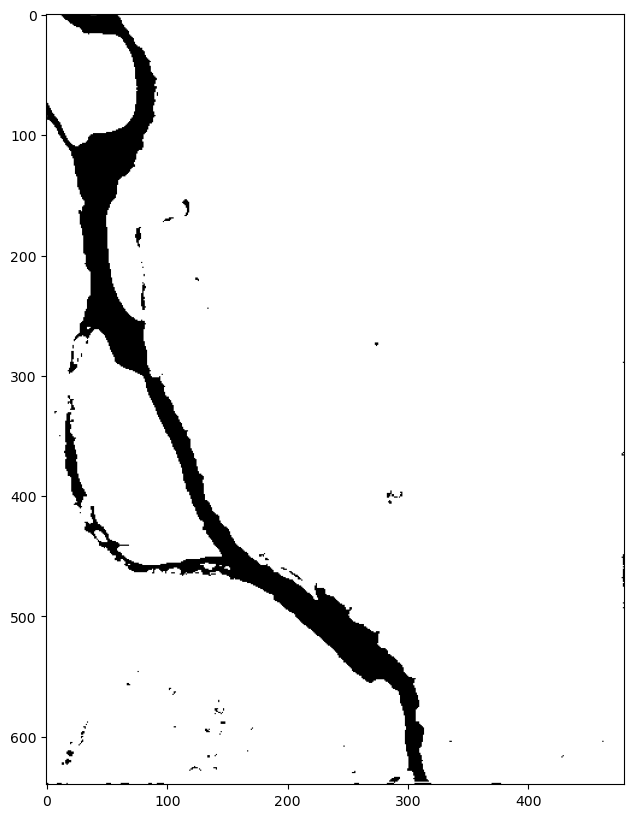

In [71]:
def getRoughRiverMask(datapoint, do_print = False, return_components = False):
  rgb_image = cv2.imread(str(datapoint["rgb_path"]))
  ir_image = cv2.imread(str(datapoint["ir_path"]), cv2.IMREAD_GRAYSCALE)

  low_blue = [hue_slider.value[0], sat_slider.value[0], val_slider.value[0]] # [75, 10, 20]
  high_blue = [hue_slider.value[1], sat_slider.value[1], val_slider.value[1]] # [140, 200, 230]

  if do_print: print("Creating mask via HSV thresholding...\nBounds:", low_blue, high_blue)
  return createRoughRiverMask(rgb_image, ir_image, low_blue, high_blue, temp_slider.value, return_components)

mask = getRoughRiverMask(datapoint, do_print=True)
plt.figure(figsize=(10,10))
plt.imshow(cv2.bitwise_not(mask), cmap="gray")
plt.axis("on")
plt.show()

In [72]:
"""
Adapted from Facebook's SAM predictor 
example workflow notebook.
"""

def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)   
    
def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0,0,0,0), lw=2))    

In [73]:
import numpy as np

def controlPointsFromMask(mask, number, distance=0, positive=False):
  input_points = []

  def euclideanDistance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

  while len(input_points) < number:
    zero_indices = np.argwhere(mask != 0) if positive else np.argwhere(mask == 0)

    if len(zero_indices) > 0:

      found_valid = False
      while not found_valid:
        random_index = np.random.randint(0, len(zero_indices))
        row, col = zero_indices[random_index]
        new_point = [col, row]
        
        # Check if the new point is far enough from existing points
        too_close = False
        for point in input_points:
          if euclideanDistance(point, new_point) < distance:
            too_close = True
            break

        if not too_close:
          input_points.append(new_point)
          found_valid = True
          break
        else:
          zero_indices = np.delete(zero_indices, random_index, axis=0)
          if len(zero_indices) == 0:
            break
      # end while

      if not found_valid: # There are points left but none with enough distance between them.
        break
    
    else:
      break  # We have fewer than "number" points, but there are no valid points left.

  return np.array(input_points)

def generateInputPointsFromMask(
  number = None, 
  mask = None, 
  minDistance = 0,
  negativeSrcMask = None,
  numNegative = None,
  positiveSrcMask = None,
  numPositive = None,
):
  input_points = []
  input_labels = []

  _numNegative = numNegative if numNegative is not None else number
  if _numNegative is not None:
    control_points = controlPointsFromMask(
      negativeSrcMask if negativeSrcMask is not None else mask,
      _numNegative,
      distance=minDistance
    )
    input_points.extend(control_points)
    input_labels.extend([0] * len(control_points))

  _numPositive = numPositive if numPositive is not None else number
  if _numPositive is not None:
    control_points = controlPointsFromMask(
      positiveSrcMask if positiveSrcMask is not None else mask,
      _numPositive,
      distance=minDistance,
      positive=True
    )
    input_points.extend(control_points)
    input_labels.extend([1] * len(control_points))

  input_points = np.array(input_points)
  input_labels = np.array(input_labels)

  return input_points, input_labels

square = np.array([
  [1,1,1],
  [1,1,1],
  [1,1,1],
])

def multiErode(im, num, element=square):
  for i in range(num):
    im = erosion(im, element)
  return im

In [74]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

# TODO: fetch model if it isn't downloaded
sam_checkpoint = "../data/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = None

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

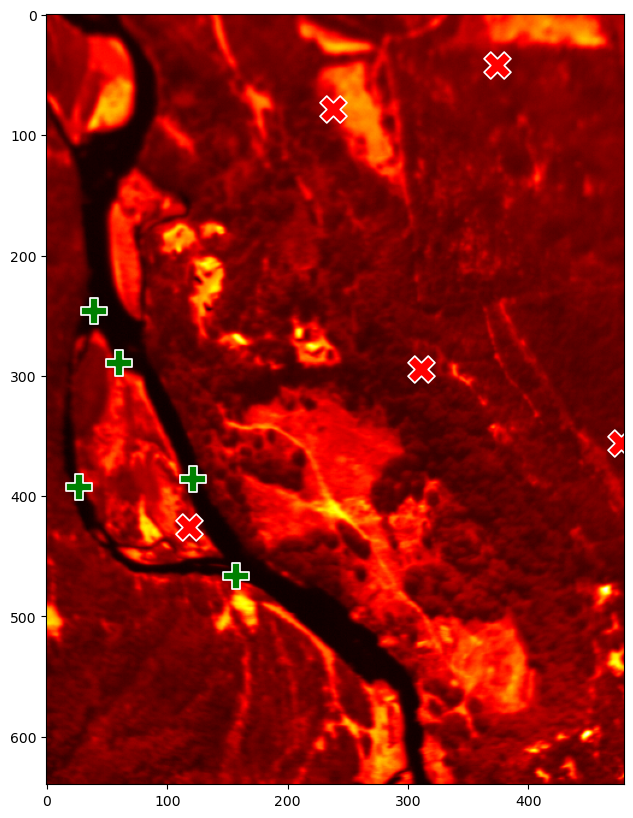

In [92]:
image = cv2.imread(str(datapoint["ir_path"]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = getRoughRiverMask(datapoint)
input_points, input_labels = generateInputPointsFromMask(number=5, mask=mask)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_points, input_labels, plt.gca())
plt.show()

In [78]:
erode_slider = widgets.IntSlider(
  value=5,
  min=0, max=15, step=1,
  description="Erosion Factor:",
)
distance_slider = widgets.IntSlider(
  value=50,
  min=0, max=100, step=5,
  description="Min Distance:",
)
points_slider = widgets.IntSlider(
  value=5,
  min=2, max=15, step=1,
  description="Control Points:",
)

def getControlPoints(
  num_points = points_slider.value, 
  erosion_factor = erode_slider.value, 
  min_distance = distance_slider.value, 
  give_erosion_mask = False
):
  mask = getRoughRiverMask(datapoint)
  binarized = mask > 1
  eroded = multiErode(binarized, erosion_factor)
  result = generateInputPointsFromMask(numPositive=num_points, positiveSrcMask=eroded, minDistance=min_distance)

  if give_erosion_mask:
    return eroded, result
  return result

def updateControlPoints(erosion_factor, num_points, min_distance, force_refresh):
  eroded, (input_points, input_labels) = getControlPoints(num_points, erosion_factor, min_distance, give_erosion_mask=True)
  figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

  axes[0].imshow(eroded)
  axes[1].imshow(image)
  show_points(input_points, input_labels, axes[1])

  plt.show()

randomize_button = widgets.ToggleButton(
  value=False,
  description="Generate",
  disabled=False,
)

interactive_plot = widgets.interactive(
  updateControlPoints, 
  erosion_factor=erode_slider,
  num_points=points_slider,
  min_distance=distance_slider,
  force_refresh=randomize_button,
)
display(interactive_plot)

interactive(children=(IntSlider(value=5, description='Erosion Factor:', max=15), IntSlider(value=5, descriptio…

Facebook's SAM provides 3 model sizes. For our purposes the smallest of the three, ViT-B, will suffice. The model checkpoint can be downloaded from [this](https://github.com/facebookresearch/segment-anything#model-checkpoints) link.

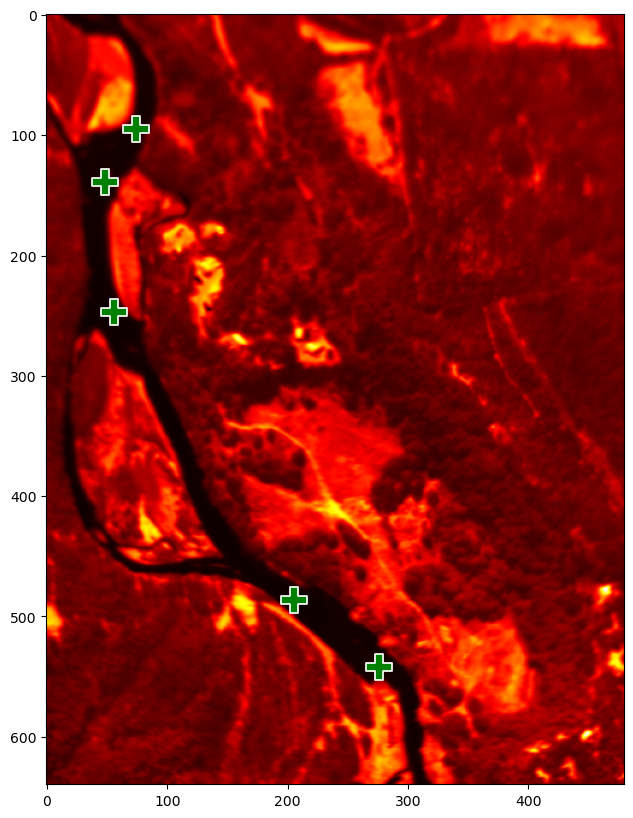

In [79]:
input_points, input_labels = getControlPoints()

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_points, input_labels, plt.gca())
plt.show()

In [80]:
predictor.set_image(image)

In [81]:
masks, scores, logits = predictor.predict(
  point_coords=input_points,
  point_labels=input_labels,
  multimask_output=False,
)

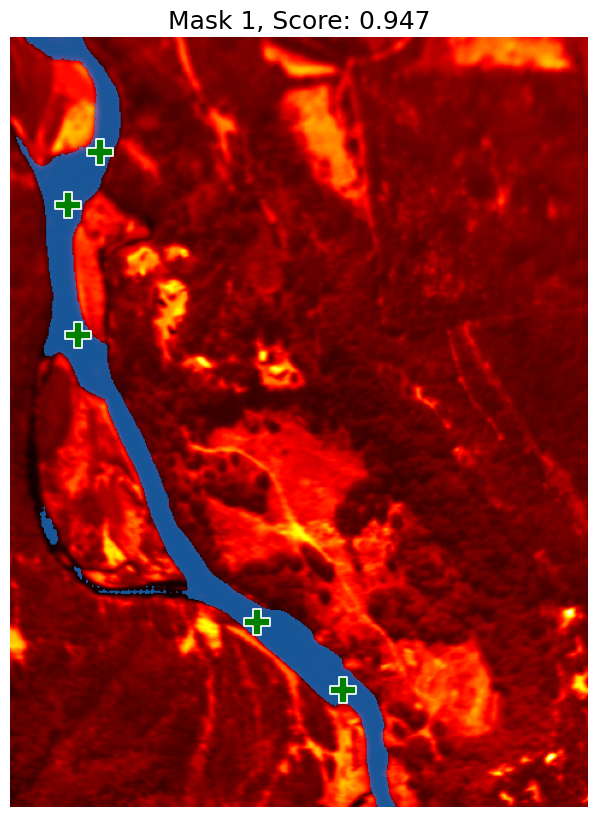

In [82]:
for i, (mask, score) in enumerate(zip(masks, scores)):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  show_mask(mask, plt.gca())
  show_points(input_points, input_labels, plt.gca())
  plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
  plt.axis("off")
  plt.show()  

In [83]:
def evaluateMaskAccuracy(datapoint, prediction, control_points = None, best_values = None):
  best_input_points = best_input_labels = best_index = best_score = all_scores = best_erosion = None
  if control_points is not None: best_input_points, best_input_labels = control_points
  if best_values is not None: best_index, best_score, all_scores, best_erosion = best_values

  rgb_image = cv2.imread(str(datapoint["rgb_path"]))
  rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
  
  truth = cv2.imread(str(datapoint["mask_path"]))
  truth = cv2.bitwise_not(truth)[:,:,0].astype(np.int32)

  prediction = np.where(prediction, 255, 0)
  error = cv2.bitwise_xor(prediction, truth)

  print("Misclasified pixels:", np.count_nonzero(error))
  print("Total river pixels:", np.count_nonzero(truth))
  print(f"Error rate: {100 * round(np.count_nonzero(error) / np.count_nonzero(truth), 4)}%")

  # print(f"Error rate: {100 * round(np.count_nonzero(error) / (prediction.shape[0] * prediction.shape[1]), 4)}%")

  plot_images = [rgb_image, prediction, truth, error]
  figure, axes = plt.subplots(nrows=1, ncols=len(plot_images), figsize=(15,15))

  if control_points is not None:
    show_mask(prediction, axes[0])
    show_points(best_input_points, best_input_labels, axes[0])

  for idx, mask in enumerate(plot_images):
    axes[idx].imshow(mask, cmap="grey")
    axes[idx].axis("off")

  if best_values is not None:
    plot_title = f"Mask {best_index} (Score: {best_score:.3f})"
    if best_erosion is not None: plot_title = f"Mask {best_index} (Erosion: {best_erosion}, Score: {best_score:.3f})"
    plt.title(plot_title, fontsize=18)
    
    print(f"Minimum Score: {np.min(all_scores)}")
    print(f"Median Score: {np.median(all_scores)}")
    print(f"Mean Score: {np.mean(all_scores)}")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 5374
Total river pixels: 17676
Error rate: 30.4%


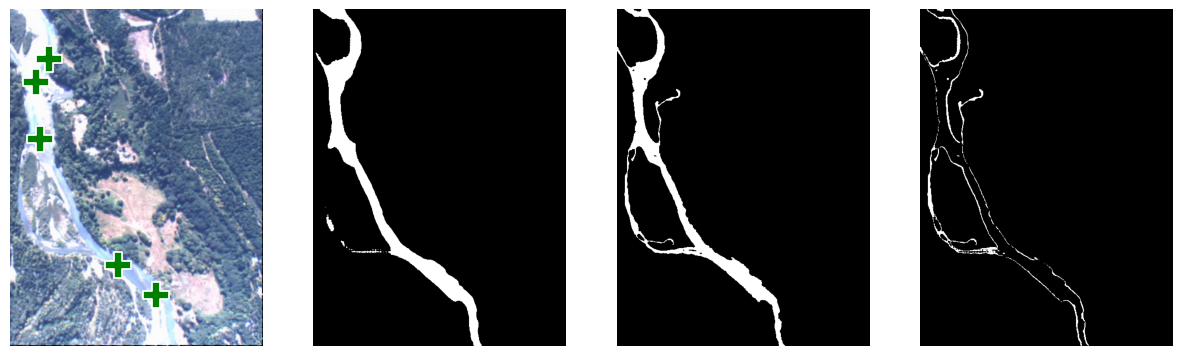

In [84]:
evaluateMaskAccuracy(datapoint, mask, (input_points, input_labels))

In [48]:
def bestOfMultiRoundPrediction(image, num_rounds: int, erosion_range: range = None):
  # print("Setting predictor image...", end="\r")
  predictor.set_image(image)

  all_scores = []

  best_index, best_mask, best_score, best_erosion = [0, None, 0, None]
  best_input_points, best_input_labels = [None, None]

  _erosion_range = erosion_range if erosion_range is not None else [None]

  for erosion_val in _erosion_range:
    for i in range(num_rounds):
      # print(f"Computing prediction round #{i} with erosion={erosion_val}", end="   \r")
      input_points, input_labels = getControlPoints(erosion_factor=erosion_val)

      if len(input_points) == 0: continue
      masks, scores, _logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        # multimask_output=True,
        multimask_output=False,
      )
      
      all_scores.append(scores[0])
      if (scores[0] > best_score):
        best_index = i
        best_score = scores[0]
        best_mask = masks[0]
        best_erosion = erosion_val

        best_input_points = input_points
        best_input_labels = input_labels

  return best_mask, (best_input_points, best_input_labels), (best_index, best_score, all_scores, best_erosion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 649
Total river pixels: 4958
Error rate: 13.089999999999998%
Minimum Score: 0.6977757215499878
Median Score: 0.9661865830421448
Mean Score: 0.9371496438980103


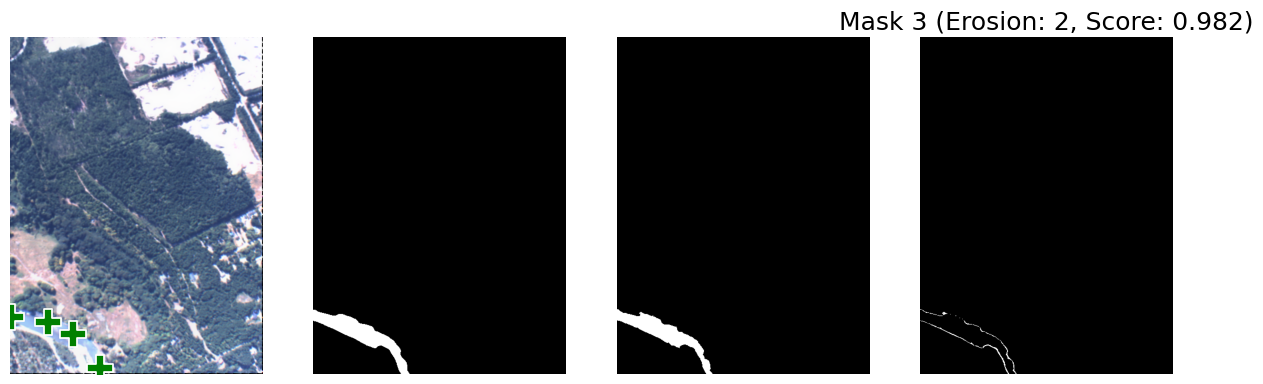

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 5220
Total river pixels: 17676
Error rate: 29.53%
Minimum Score: 0.9239458441734314
Median Score: 0.9483767747879028
Mean Score: 0.9478647708892822


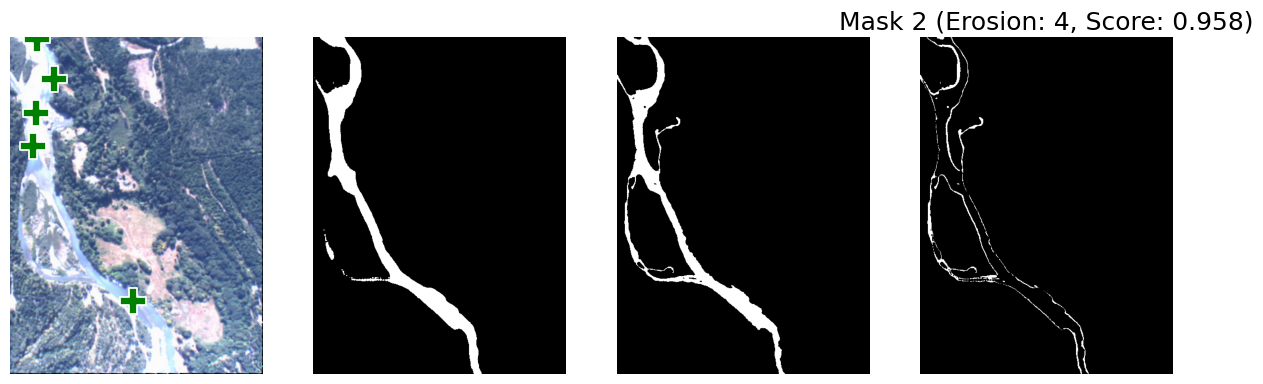

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 1234
Total river pixels: 8032
Error rate: 15.36%
Minimum Score: 0.8378064036369324
Median Score: 0.9529841542243958
Mean Score: 0.945024847984314


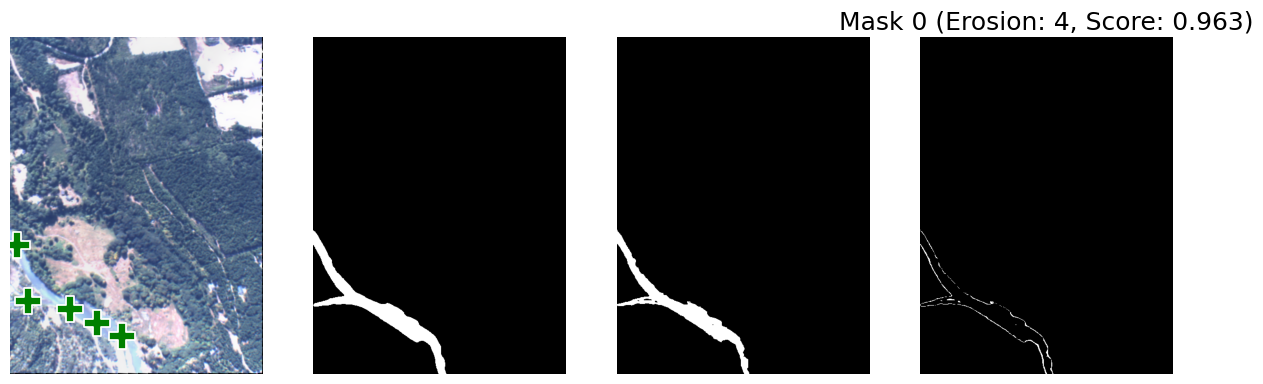

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 8550
Total river pixels: 14306
Error rate: 59.77%
Minimum Score: 0.8160128593444824
Median Score: 0.8909616470336914
Mean Score: 0.8871645927429199


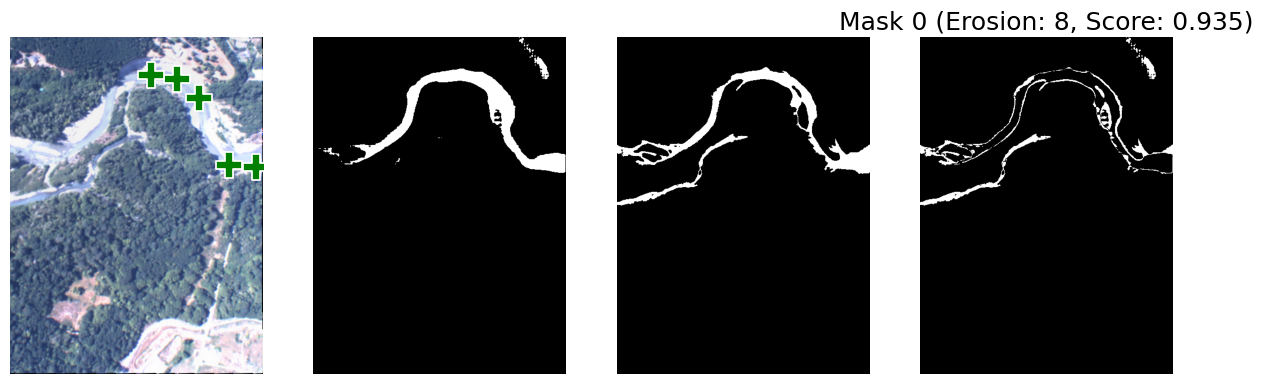

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 290079
Total river pixels: 12585
Error rate: 2304.96%
Minimum Score: 0.6994831562042236
Median Score: 0.785735011100769
Mean Score: 0.7816380262374878


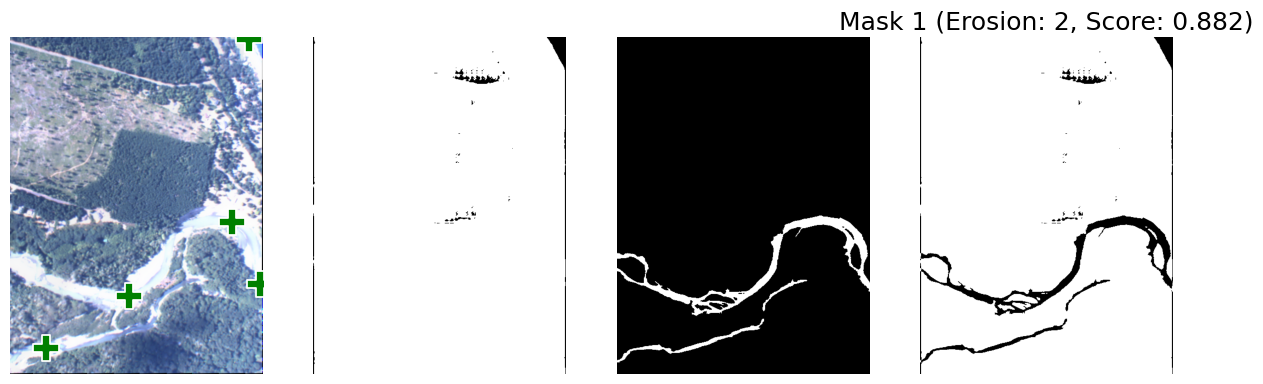

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 137032
Total river pixels: 11304
Error rate: 1212.24%
Minimum Score: 0.638766884803772
Median Score: 0.8547325134277344
Mean Score: 0.8219730257987976


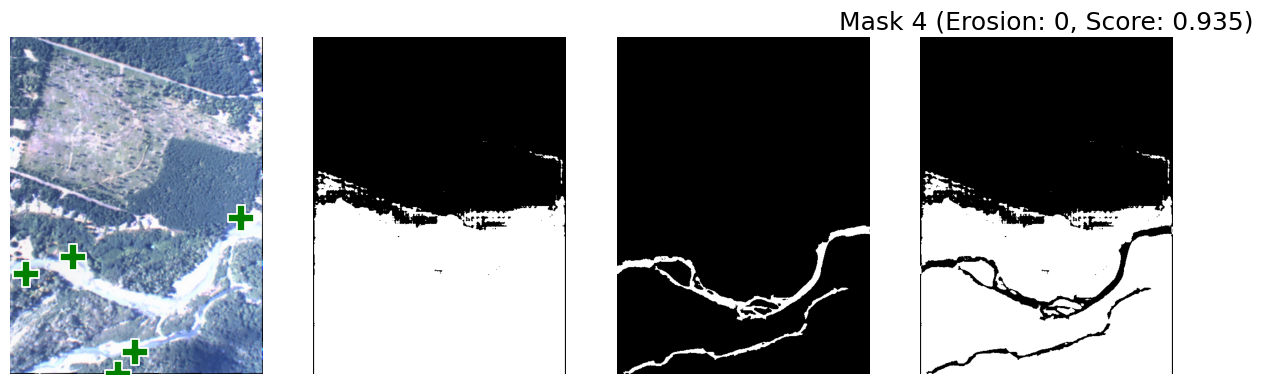

In [63]:
for sample_idx in range(len(data)):
  datapoint = data[sample_idx]
  image = cv2.imread(str(datapoint["ir_path"]))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  best_mask, control_points, best_values = bestOfMultiRoundPrediction(image, 5, range(0, 10, 2))
  evaluateMaskAccuracy(datapoint, best_mask, control_points, best_values)

In [ ]:
# model = predictor.features

# for param in model.parameters():
#   param.requires_grad = False

# num_features = model.fc.in_features
# classifier = torch.nn.Linear(num_features, 2)

In [ ]:
# for name, module in sam.named_modules():
#   print(name, module)

NOTE TO SELF:\
ir_image_{x} matches with cropped_{x-1} and with truth_{x}
ir images are degree in celsius